In [13]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from einops.layers.torch import Rearrange
from einops import rearrange
from tqdm.notebook import tqdm

In [14]:
class CocoDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
    
    def __getitem__(self, idx):
        return self.data[idx][0] #only use img
    
    def __len__(self):
        return len(self.data)

In [15]:
root = "/home/bingyu/DLHandbook/dataset/coco/train2017"
annFile = "/home/bingyu/DLHandbook/dataset/coco/annotations/instances_train2017.json"
transform = torchvision.transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor()]
)
coco = torchvision.datasets.CocoDetection(root, annFile, transform=transform)

train_dataset, val_dataset = torch.utils.data.random_split(
    coco, [80000, 118287 - 80000]
)
train_dataset = CocoDataset(train_dataset)
val_dataset = CocoDataset(val_dataset)

train_sampler = torch.utils.data.SubsetRandomSampler(range(1000))
val_sampler = torch.utils.data.SubsetRandomSampler(range(5000,5020))
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, num_workers=2, sampler=train_sampler,
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=8, num_workers=2, sampler=val_sampler,
)

print(f"train_loader:{len(train_loader)}, val_loader:{len(val_loader)}")

loading annotations into memory...
Done (t=15.61s)
creating index...
index created!
train_loader:63, val_loader:3


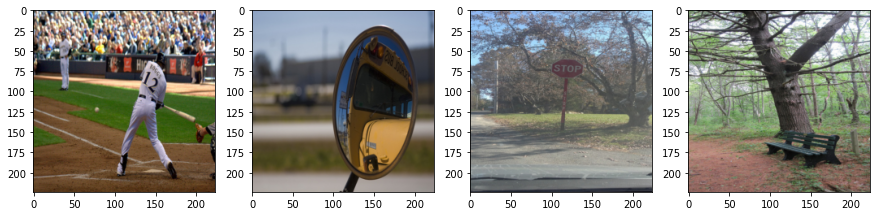

In [16]:
for img in train_loader:
    fig, ax = plt.subplots(1,4, figsize=(15,10))
    ax[0].imshow(img[0].permute(1,2,0))
    ax[1].imshow(img[2].permute(1,2,0))
    ax[2].imshow(img[4].permute(1,2,0))
    ax[3].imshow(img[7].permute(1,2,0))
    break

In [17]:
class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=256, dropout=0):
        super().__init__()
        self.heads = heads
        self.dim_head = dim_head

        inner_dim = heads * dim_head

        self.key = nn.Linear(dim, inner_dim)
        self.query = nn.Linear(dim, inner_dim)
        self.value = nn.Linear(dim, inner_dim)

        self.proj = nn.Linear(inner_dim, dim)

    def forward(self, x):
        B, N, C = x.shape

        key = (
            self.key(x).view(B, N, self.heads, self.dim_head).transpose(1, 2)
        )  # B, nh, N, D
        query = self.query(x).view(B, N, self.heads, self.dim_head).transpose(1, 2)
        value = self.value(x).view(B, N, self.heads, self.dim_head).transpose(1, 2)

        scale = self.dim_head ** -0.5
        att = (query @ key.transpose(-2, -1)) * scale  # B, nh, N, N
        att = F.softmax(att, dim=-1)
        att = att @ value  # B, nh, N, D
        att = att.transpose(1, 2).reshape(B, N, self.heads * self.dim_head)

        out = self.proj(att)
        return out


class Transformer(nn.Module):
    def __init__(self, depth, num_heads, dim, hid_dim, dropout):
        super().__init__()
        self.layers = []

        for _ in range(depth):
            atten = nn.Sequential(nn.LayerNorm(dim), Attention(dim, num_heads))
            mlp = nn.Sequential(
                nn.LayerNorm(dim),
                nn.Linear(dim, hid_dim),
                nn.GELU(),
                nn.Linear(hid_dim, dim),
                nn.Dropout(dropout),
            )
            self.layers.append(nn.ModuleList([atten, mlp]))
        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        for atten, mlp in self.layers:
            x = atten(x) + x
            x = mlp(x) + x
        return x


In [18]:
def encodePosition1DSinCos(dim, grid):
    assert dim%2 ==0
    omega = np.arange(dim//2, dtype=np.float32)
    omega = omega / (dim//2)
    omega = 1. / 10000 ** omega

    grid = grid.reshape(-1)
    out = np.einsum('n,h->nh', grid, omega) # (n, D/2)

    emb_sin = np.sin(out)
    emb_cos = np.cos(out)
    emb = np.concatenate([emb_sin, emb_cos], axis=-1)
    return emb

def encodePosition2DSinCos(dim, grid):
    assert dim % 2 == 0

    emb_h = encodePosition1DSinCos(dim//2, grid[0])
    emb_w = encodePosition1DSinCos(dim//2, grid[1])

    emb = np.concatenate([emb_h, emb_w], axis=-1)
    return emb


<ipython-input-19-a01eb4178e56>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grid_h = np.arange(grid_size, dtype=np.float)


Text(0.5, 1.0, '1D sincos position encoding')

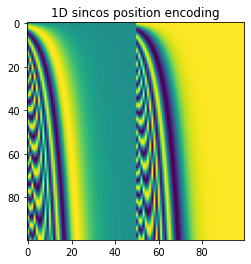

In [19]:
grid_size = 100
grid_h = np.arange(grid_size, dtype=np.float)

emb = encodePosition1DSinCos(100, grid_h)

plt.figure()
plt.imshow(emb)
plt.title("1D sincos position encoding")

<ipython-input-20-4cd27d15dc5d>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grid_h = np.arange(grid_size, dtype=np.float)
<ipython-input-20-4cd27d15dc5d>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grid_w = np.arange(grid_size, dtype=np.float)


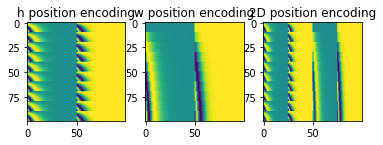

In [20]:
grid_size = 10
grid_h = np.arange(grid_size, dtype=np.float)
grid_w = np.arange(grid_size, dtype=np.float)
grid = np.meshgrid(grid_w, grid_h)
grid = np.stack(grid, axis=0)
emb0 = encodePosition1DSinCos(100, grid[0])
emb1 = encodePosition1DSinCos(100, grid[1])
emb = encodePosition2DSinCos(100, grid)
fig, ax = plt.subplots(1,3)
ax[0].imshow(emb0)
ax[0].set_title("h position encoding")
ax[1].imshow(emb1)
ax[1].set_title("w position encoding")
ax[2].imshow(emb)
ax[2].set_title("2D position encoding")
plt.show()

In [21]:
class MAE(nn.Module):
    def __init__(self, img_h, img_w, patch_h, patch_w, encoder_emb_dim, decoder_emb_dim, mask_ratio) -> None:
        super().__init__()

        self.patch_h = patch_h
        self.patch_w = patch_w
        self.mask_ratio = mask_ratio
        self.encoder_emb_dim = encoder_emb_dim

        self.num_patch = (img_h // patch_h) * (img_w // patch_w)
        patch_dim = 3 * patch_h * patch_w

        # self.path_embed = nn.Sequential(
        #     nn.Conv2d(
        #         in_channels=3,
        #         out_channels=emb_dim,
        #         kernel_size=(patch_h, path_w),
        #         stride=(patch_h, path_w),
        #     ),
        #     nn.Flatten(),
        # )

        self.to_patch = Rearrange(
            "b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=patch_h, p2=patch_w
        )

        self.patch_embed = nn.Linear(patch_dim, encoder_emb_dim)

        self.position_encoding = nn.Parameter(torch.randn(1, self.num_patch, encoder_emb_dim), requires_grad=False) # fixed sincos

        self.encoder = Transformer(depth=3, num_heads=2, dim=encoder_emb_dim, hid_dim=2*encoder_emb_dim, dropout=0.0)
        self.encoder_norm = nn.LayerNorm(encoder_emb_dim)

        # self.encoder_proj_decoder = nn.Linear(encoder_emb_dim, decoder_emb_dim)

        self.decoder = Transformer(depth=1, num_heads=2, dim=decoder_emb_dim, hid_dim=2*decoder_emb_dim, dropout=0.0)
        self.decoder_norm = nn.LayerNorm(decoder_emb_dim)
        self.mask_token = nn.Parameter(torch.randn(decoder_emb_dim))

        self.to_pixels = nn.Linear(decoder_emb_dim, patch_dim)

        self.initialize()
    
    def initialize(self):
        grid_size = int(self.num_patch ** 0.5)
        grid_h = np.arange(grid_size, dtype=np.float)
        grid_w = np.arange(grid_size, dtype=np.float)
        grid = np.meshgrid(grid_w, grid_h)
        grid = np.stack(grid, axis=0)
        self.position_encoding.data.copy_(torch.from_numpy(encodePosition2DSinCos(self.encoder_emb_dim, grid)).type(torch.float).unsqueeze(0))

        nn.init.xavier_uniform_(self.patch_embed.weight.data)
        nn.init.normal_(self.mask_token, std=0.02)

        def init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
        
        self.apply(init_weights)
        

    def forward(self, x):
        """
        x: B,C,H,W
        """
        # patch embedding
        x = self.to_patch(x)  # B,N,C
        patch_emb = self.patch_embed(x)  # B,N,D

        # position encode
        patch_emb += self.position_encoding

        # masking
        B, N, *_ = patch_emb.shape
        num_masked = int(N * self.mask_ratio)
        rand_indice = torch.rand(B, N).argsort(dim=-1)
        masked_indice = rand_indice[:, :num_masked]
        unmasked_indice = rand_indice[:, num_masked:]

        # encoder
        encoded_token = self.encoder(patch_emb[torch.arange(B)[:,None], unmasked_indice, :])
        encoded_token = self.encoder_norm(encoded_token)

        # decoder
        mask_tokens = self.mask_token.repeat(B, num_masked, 1)
        mask_tokens += self.position_encoding[:, masked_indice, :].squeeze()

        encoded_token += self.position_encoding[:, unmasked_indice, :].squeeze()

        decoder_tokens = torch.cat((encoded_token, mask_tokens), dim=1)  # B,N,D
        decoder_tokens = self.decoder(decoder_tokens)
        decoder_tokens = self.decoder_norm(decoder_tokens)

        masked_tokens = decoder_tokens[:, -num_masked:]
        masked_pixel = self.to_pixels(masked_tokens)

        masked_patches = x[torch.arange(B)[:,None], masked_indice]
        
        loss = F.mse_loss(masked_pixel, masked_patches)

        return loss, masked_pixel.detach(), masked_patches.detach()


In [22]:
def plot(gt_img, pred_patches, target_patches):
    print(f"pred_patches: {pred_patches.shape}, target_patches: {target_patches.shape}")
    fig1, ax1 = plt.subplots(1,1)
    ax1.imshow(gt_img.permute(1,2,0))
    fig2, ax2 = plt.subplots(6,6)
    for i in range(36):
        ax2[i//6, i%6].imshow(pred_patches[i])
    fig3, ax3 = plt.subplots(6,6)
    for i in range(36):
        ax3[i//6, i%6].imshow(target_patches[i])
    fig1.show()
    fig2.show()
    fig3.show()
    


In [23]:
model = MAE(224, 224, 16, 16, 512, 512, mask_ratio=0.75)

print(model)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.95))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

for epoch in range(60):
    epoch_loss = 0
    model.train()
    for imgs in tqdm(train_loader):
        loss, *_ = model(imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss/len(train_loader)

        # masked_patch_pred = rearrange(masked_pixel, 'b n (p1 p2 c) -> b n p1 p2 c', p1=16, p2=16)
        # masked_patches_target = rearrange(masked_patches, 'b n (p1 p2 c) -> b n p1 p2 c', p1=16, p2=16)

        # plot(imgs[0], masked_patch_pred[0], masked_patches_target[0])
    
    
    with torch.no_grad():
        epoch_val_loss = 0
        model.eval()
        for imgs in val_loader:
            val_loss, *_ = model(imgs)
            epoch_val_loss += val_loss / len(val_loader)

    print(f"Epoch: {epoch}, lr: {scheduler.get_lr()}train_loss: {epoch_loss}, val_loss: {epoch_val_loss}")
    scheduler.step()

MAE(
  (to_patch): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
  (patch_embed): Linear(in_features=768, out_features=512, bias=True)
  (encoder): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Sequential(
          (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (1): Attention(
            (key): Linear(in_features=512, out_features=512, bias=True)
            (query): Linear(in_features=512, out_features=512, bias=True)
            (value): Linear(in_features=512, out_features=512, bias=True)
            (proj): Linear(in_features=512, out_features=512, bias=True)
          )
        )
        (1): Sequential(
          (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=512, out_features=1024, bias=True)
          (2): GELU()
          (3): Linear(in_features=1024, out_features=512, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): ModuleL

<ipython-input-21-54a18fdfcaf8>:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grid_h = np.arange(grid_size, dtype=np.float)
<ipython-input-21-54a18fdfcaf8>:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grid_w = np.arange(grid_size, dtype=np.float)


  0%|          | 0/63 [00:00<?, ?it/s]

pred_patches: torch.Size([147, 16, 16, 3]), target_patches: torch.Size([147, 16, 16, 3])


<ipython-input-10-346595eacba5>:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
<ipython-input-10-346595eacba5>:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
<ipython-input-10-346595eacba5>:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


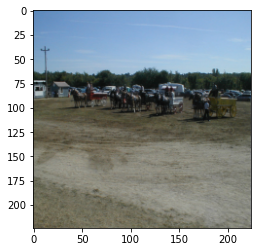

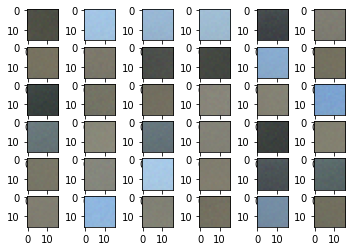

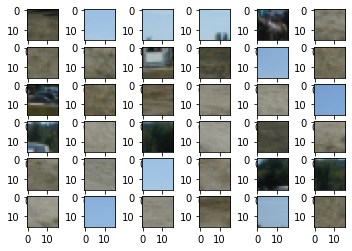

In [ ]:
with torch.no_grad():
    model.eval()
    for imgs in train_loader:
        _, masked_pixel, masked_patches = model(imgs)
        masked_patch_pred = rearrange(masked_pixel, 'b n (p1 p2 c) -> b n p1 p2 c', p1=16, p2=16)
        masked_patches_target = rearrange(masked_patches, 'b n (p1 p2 c) -> b n p1 p2 c', p1=16, p2=16)

        plot(imgs[0], masked_patch_pred[0], masked_patches_target[0])
        break